In [23]:
import os
import sys
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
import configs

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'

In [3]:
# Set up parameters
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'
n_timesteps = 5

Device: cuda:0


# Pnets to Compare

In [26]:
pnets = [
    'pnet', 'pnet_noisy',
    'pnet_temp_shuffle', 'pnet_freq_shuffle'
    ]
pnet_names = [
    'Main', 'N', 'TS', 'FS'
    ]

In [5]:
n_pnets = len(pnets)

In [6]:
n_layers = 5
layer_keys = [
    'pcoder1.pmodule.1.weight', 'pcoder2.pmodule.1.weight',
    'pcoder3.pmodule.1.weight', 'pcoder4.pmodule.0.weight',
    'pcoder5.pmodule.0.weight'
    ]

In [15]:
state_dicts = [[] for _ in range(n_pnets)]

for pnet_idx, pnet in enumerate(pnets):
    for iteration in range(1,4):
        pnet_string = pnet
        if iteration > 1:
            pnet_string += str(iteration)
        chckpt_dir = f'{checkpoints_dir}{pnet_string}'
        pattern = re.compile(f'^{pnet_string}-(\d+)-regular\.pth$')
        checkpoints = []
        for filename in os.listdir(chckpt_dir):
            match = pattern.match(filename)
            if match:
                checkpoints.append(int(match.group(1)))
        chckpt = max(checkpoints)
        print(f'{pnet_string}: {chckpt}')
            
        state_dict = torch.load(
            f"{chckpt_dir}/{pnet_string}-{chckpt}-regular.pth",
            map_location=torch.device('cpu')
            )
        state_dicts[pnet_idx].append(state_dict)

pnet: 1960
pnet2: 2000
pnet3: 1785
pnet_noisy: 2000
pnet_noisy2: 2000
pnet_noisy3: 2000
pnet_temp_shuffle: 2140
pnet_temp_shuffle2: 2000
pnet_temp_shuffle3: 2000
pnet_freq_shuffle: 2300
pnet_freq_shuffle2: 1750
pnet_freq_shuffle3: 2000


# Gather similarity measures

In [16]:
from scipy.stats import pearsonr
from numpy.linalg import norm

In [21]:
sims = [np.zeros((n_pnets, n_pnets)) for _ in range(n_layers)]
for i, state_dict_i_list in enumerate(state_dicts):
    for j, state_dict_j_list in enumerate(state_dicts):
        for layer_idx, key in enumerate(layer_keys):
            fb_i_all = [sd[key].flatten() for sd in state_dict_i_list]
            fb_j_all = [sd[key].flatten() for sd in state_dict_j_list]
            corrs = []
            for k in range(len(fb_i_all)):
                for l in range(k+1, len(fb_j_all)):
                    if (i==j) and (l <= k): continue
                    corr = pearsonr(fb_i_all[k], fb_j_all[l])
                    corrs.append(corr)
            sims[layer_idx][i][j] = np.mean(corrs)

# Plot

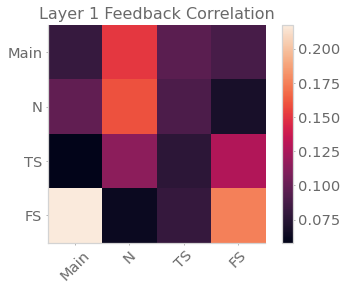

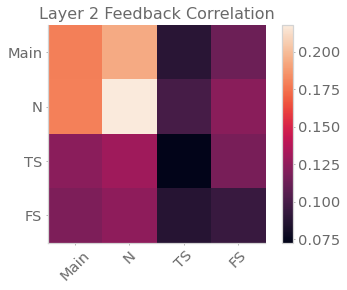

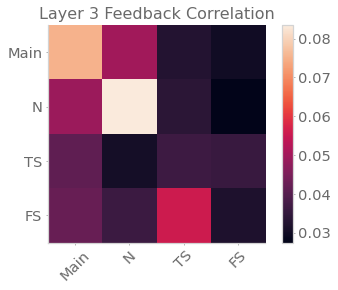

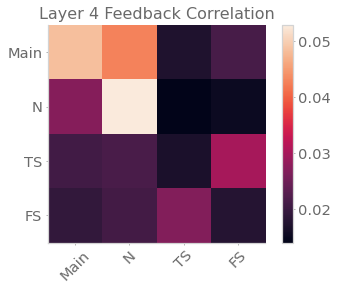

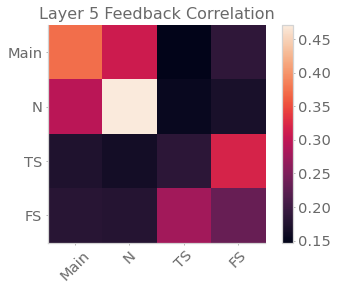

In [27]:
for layer, sim in enumerate(sims):
    plt.figure()
    plt.imshow(sim)
    plt.xticks(np.arange(n_pnets), pnet_names, rotation=45)
    plt.yticks(np.arange(n_pnets), pnet_names)
    plt.colorbar()
    plt.title(f'Layer {layer+1} Feedback Correlation')
    plt.show()

# Shuffled

In [ ]:
sims = [np.zeros((n_pnets, n_pnets)) for l in range(n_layers)]
for i, state_dict_i in enumerate(state_dicts):
    for j, state_dict_j in enumerate(state_dicts):
        if i == j: continue
        for l, key in enumerate(layer_keys):
            fb_i = state_dict_i[key].flatten()
            fb_j = state_dict_j[key].flatten()
            np.random.shuffle(fb_i)
            np.random.shuffle(fb_j)
            r, _ = pearsonr(fb_i, fb_j)
            #r = np.dot(fb_i, fb_j)/(norm(fb_i)*norm(fb_j))
            #r = norm(fb_i - fb_j)
            sims[l][i][j] = r

In [ ]:
for sim in sims:
    plt.figure()
    plt.imshow(sim)
    plt.xticks(np.arange(n_pnets), pnet_names, rotation=45)
    plt.yticks(np.arange(n_pnets), pnet_names)
    plt.colorbar()
    plt.show()